Import required libraries

In [12]:
from navground import sim,core
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial.distance as dist
import matplotlib.colors as colors
import matplotlib.cm as cmx
from navground.sim.ui.video import display_video, display_video_from_run
from tqdm import tqdm

Step 1) We conduct experiments, in this case we conduct an simulation with a time instances and b robots. In addition each time step has a time step c. 

In this case it is a single simulation(run=1) with 20 robots, and 500 time instances with a time jump of 0.01 secondx between each instance. We have the cross scenario with a side length of 4 metres. All defined parameters are kept constant in the simulation. They have a field of view of 360 degrees (commented by Jerome). The radius of the field of view that the robot has is set in the "range" feature in "state_estimation". (also commented by Jerome). The robots are modelled after the Thymio robot, a small robot with a size of 8 cm and a two-wheel differential-drive kinematics, which is a very commm kinematics shared by many grounds robot and most smart wheelchairs. Each simulated robot executes the Human-Like navigation behavior. 

Regardless of the type of behaviour we select, we have to set the agent's size (robots), the Kinematics (Let’s pick "2WDiff", which corresponds to a robot with two differential drive wheels, one at each side of a longitudinal axis, as we are working with wheelchair in the REXASI-PRO context) and the generic parameters, such as: 

- optimal_speed: The desired optimal speed.
- horizon: the size of the portion of environment around the agent considered when computing possible collisions.
- safety_margin: The minimal safety margin to keep away from obstacles
- rotation_tau: The relaxation time to rotate towards a desired orientation


The Human-like(HL) behavior is a bio-inspired, conceptually simple and computationally light, local navigation algorithm, that extends and adapts to robotics a heuristic model for pedestrian motion

When we set the HL behavior, we can specify the following parameters/properties: 

- tau (float, tau), The relaxation time. higher values lead to lower accelerations.

- eta (float, eta), The time that the behavior keeps away from collisions. higher values lead to slower speeds.

- aperture (float, aperture), desired velocity is searched on a circular sector

- resolution (float, resolution), The number of subdivision to search for optimal directions.

- epsilon (float, epsilon),

- barrier_angle (float, barrier_angle)  the minimal angle with respect to a currently virtually colliding obstacle to ignore it

On the other hand, an simulation with "safety_margin"=0, which is an unsafe setup that will lead to collisions(robots are colored in red) and an experiment with an increasing of the "safety_margin" to 0.5, which is so large that it will rapidly lead to deadlocked agents, which are colored in blue.

We define the necessary simulation. We also run the simulation to be able to access the positions of the robots later.

In [2]:
time_instances=500
robots=20
time_step=0.1
safetyMargin=0.25
sideLength=4
radioRobot=0.08
radioVision = 5
simulations = 1
behavior="HL"
yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
    type: Cross
    agent_margin: 0.1
    side: {sideLength}
    target_margin: 0.5
    tolerance: 0.25
    groups:
      -
        type: thymio 
        number: {robots}
        radius: {radioRobot}
        control_period: 0.1
        speed_tolerance: 0.02
        kinematics:
          type: 2WDiff
          wheel_axis: 0.094
          max_speed: 0.166
        behavior:
          type: {behavior}
          optimal_speed: 0.12
          horizon: 5.0
          tau: 0.5
          eta: 0.25
          safety_margin: {safetyMargin}
        state_estimation:
          type: Bounded
          range: {radioVision}
"""

experiment = sim.load_experiment(yaml)
w = sim.World()
experiment.scenario.init_world(w,seed=0)
experiment.run()

We visualise a simulation of an initialised world with the characteristics specified in the yaml. If you notice, the display time is equal to the number of instances * the time between instances, in this case 50 seconds (500 instances with 0.1 seconds between them).

In the case of the cross scenario, we must be clear that the positions of the robots go on the x-axis from -length/2 to the value set in "length/2" of the scenario, and on the y-axis similarly. Remember that what we set in this case is the length of each side, the sideLength that we have specified.

In [3]:
def linear_map(a, b, cmap):
    c = cmx.ScalarMappable(norm=colors.Normalize(vmin=a, vmax=b), cmap=cmap)  
    def f(v):
        r, g, b, _ = c.to_rgba(v)
        return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
    return f


fill_map = linear_map(0.0, 1.0, cmap=cmx.RdYlGn)

def f(entity): #display collisions and deadlocks in the simulation
    return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) 
        else 'blue' if entity.has_been_stuck_since(run.world.time - 0.5) 
        else 'lightgreen'}



run = experiment.runs[0]
display_video_from_run(run, factor=3.0,
            bounds=(np.array([-sideLength/1.5,-sideLength/1.5]),np.array([sideLength/1.5,sideLength/1.5])), 
             decorate=f, width=600,)

Step 2) We obtain the coordinates of the robots at the different time instants. In "ps". By this, we can calculate the topological descriptors such as the persistent entropy.

We access the first run of the experiment and get the coordinates stored in the pose, as well as the orientation. Also, we need to get an idea of the maximum filtering(maximum epsilon in simplicial complex construction) value to use, which we will approximate with the largest pairwise distance between robots during the simulation in each time.

In [4]:
run = experiment.runs[0]
ps = run.poses
print(ps.shape) #has the shape of (instances of time, robots, variables coordinate + angle orientation)
maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]

(500, 20, 3)


See if a simulation has been safe and smooth (fluida):

$safe = 
\begin{cases} 
     1 & \text{if number of collisions } = 0 \\
     0 & \text{if number of collisions } > 0 
\end{cases}$

$smooth = 
\begin{cases} 
     1 & \text{if number of deadlocks } = 0 \\
     0 & \text{if number of deadlocks } > 0 
\end{cases}$

**Elements of run.collisions come in the form (time step, id_robot1, id_robot2), representing each element an specific collision, so the lenght of this array is the number of collisions in the simulation**

**Elements of run.deadlocks tell the time since agents are deadlocked, so the length of this array is the number of robots. If all  robots have negatuve number(-1) there are no deadlocks.**

In [5]:
safe = 1 if len(run.collisions) == 0 else 0
if safe == 1:
    print("This simulation is completely safe because there are no collisions.")
else:
    print("Collisions occurs in this simulation, so it's not safety")
def count_deadlocks(deadlock_time, final_time):
    is_deadlocked = np.logical_and(deadlock_time > 0, deadlock_time < (final_time - 5.0))
    return sum(is_deadlocked)
    
smooth = 1 if count_deadlocks(run.deadlocks,time_instances*time_step) == 0 else 0
if smooth == 1:
    print("This simulation is completely smooth because there are no deadlocks.")
else:
    print("Deadlocks occurs in this simulation, so it's not smooth")

This simulation is completely safe because there are no collisions.
This simulation is completely smooth because there are no deadlocks.


3. With this we can now start to perform topological data analysis and calculate the persistent entropy.

First we import the necessary libraries and let's see an example of the point cloud of the robots in the first instant of time and its persistent entropy.

In [6]:
import matplotlib.animation as animation
from matplotlib import gridspec
import math
from scipy.stats import pearsonr,shapiro

# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("../../..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

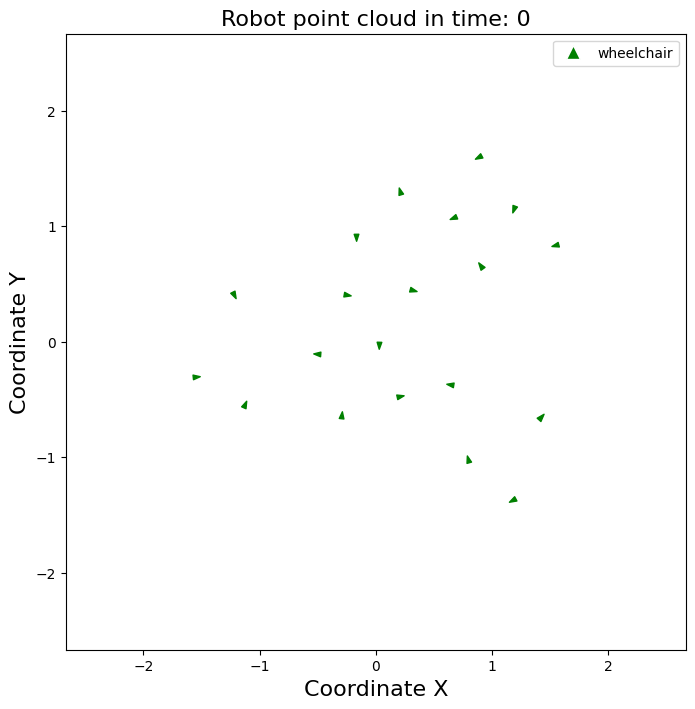

/mnt/c/Users/Victor/Documents/Repositorios/ExperimentsNavground/entorno/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:107: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Figure size 800x800 with 0 Axes>

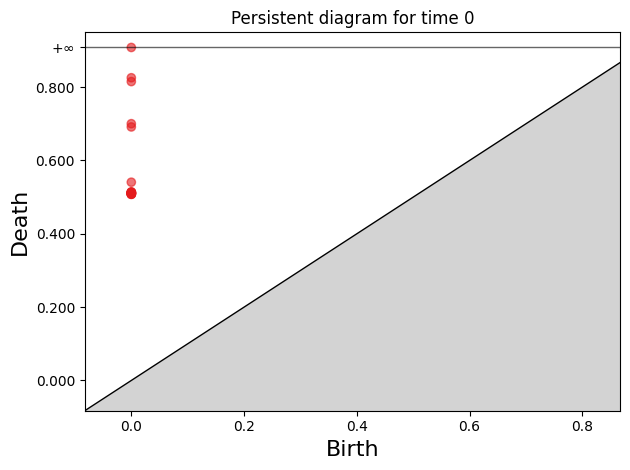

<Figure size 800x800 with 0 Axes>

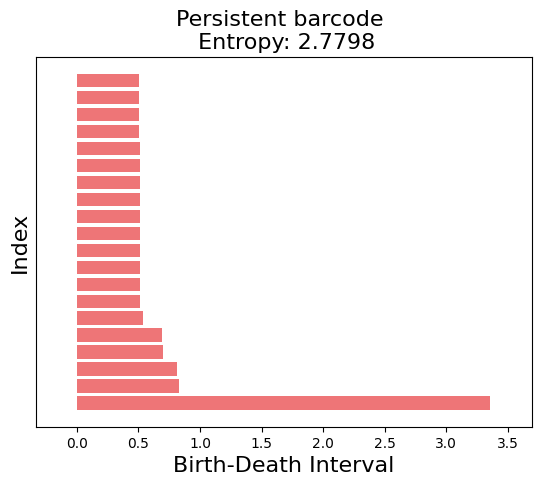

In [8]:
time=0
label_fontsize=16

typeAgents = [agent.type for agent in run.world.agents]
plt.figure(figsize=(8, 8))
fu.plotPointCloudMoment(ps,time,length=sideLength,width=sideLength,types=typeAgents)
plt.savefig(f'Images/CrossPointCloudExample{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(8, 8))
fu.plotPersistenceDiagram(ps,time,0)
plt.tight_layout()
plt.savefig(f'Images/CrossPersistentDiagramExample{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 8))
fu.plotPersistenceBarcode(ps,time,0)  
plt.savefig(f'Images/CrossPersistentBarcodeExample{behavior}.png', dpi=300, bbox_inches='tight')        
plt.show()

If we want to visualise the complete simulation in a single "interactive" graph, we can do this as well. See the graph below.

 99%|████████████████████████████████████████████████████████████████████████████████▎| 496/500 [01:39<00:18,  4.63s/it]

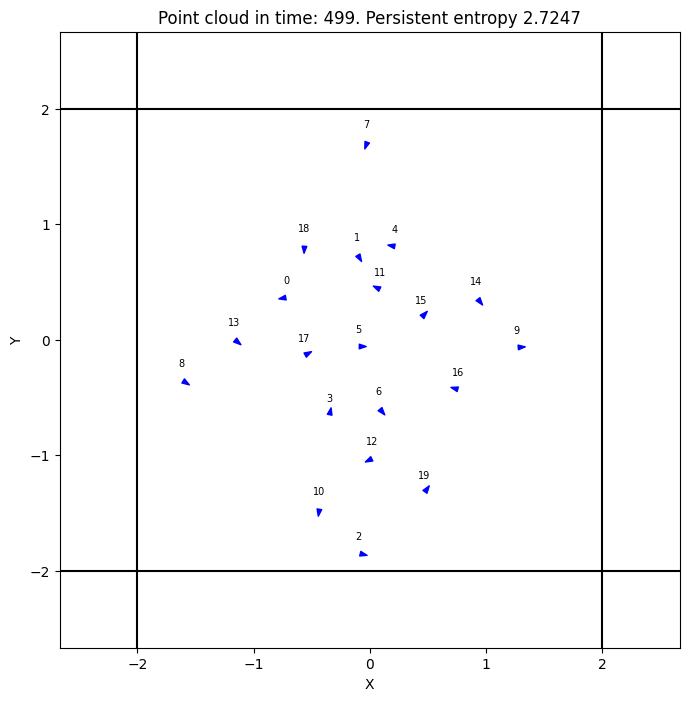

In [14]:
ids = True
    
def update(frame):
    plt.clf() 
    moment = ps[frame,:,:]
    x = moment[:, 0]
    y = moment[:, 1]
    angle = moment[:, 2]
    for (a,b,c) in zip(x,y,angle):
        marker, scale = fu.gen_arrow_head_marker(c)
        markersize = 25
        plt.scatter(a,b,marker=marker,c="blue", s=(markersize*scale)**1.5)
    plt.xlim(-sideLength/1.5, sideLength/1.5)
    plt.ylim(-sideLength/1.5, sideLength/1.5)
    plt.axhline(y=-sideLength/2, color='black')
    plt.axhline(y=sideLength/2, color='black')
    plt.axvline(x=-sideLength/2, color='black')
    plt.axvline(x=sideLength/2, color='black')
    if ids:
        for i in range(len(x)):
            plt.text(x[i], y[i]+0.1, str(i), fontsize=7, ha='center', va='bottom')
    
    persistence = fu.ComputePersistenceDiagram(ps,frame,0,"rips")
    persistenceL = fu.limitingDiagram(persistence,maxd[frame])
    entropy = fu.EntropyCalculationFromBarcode(persistenceL)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Point cloud in time: {frame}. Persistent entropy {entropy}')

fig = plt.figure(figsize=(8, 8))
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(time_instances)))
ani.save(filename=f"Images/SimulationCross{behavior}.gif", writer="pillow")
plt.show()

3) Now we can calculate the topological entropy of dimension 0 for each point cloud, for this we first calculate the persistence diagram, limit the bars that go to infinity and calculate the entropy. Finally we can plot the time series of the topology of how robots are located in each time and how they are moving.

Keep in mind that maybe the first instant will have a very large entropy, or one of the largest, since by default Navground gives them very dispersed at the beginning of the experiment.

P.S: We have created the time series plot in matplotlib and plotly to to know the instants of time that are of interest to study.

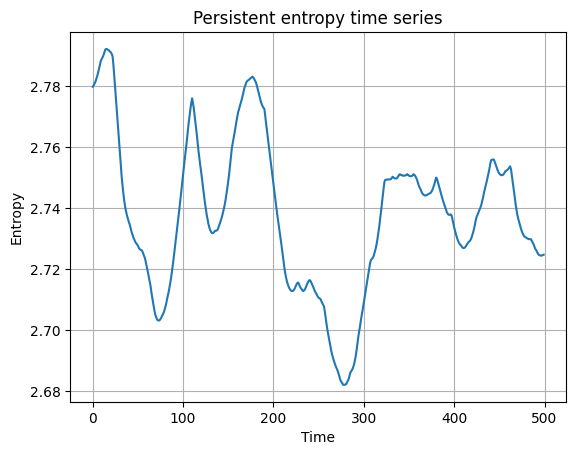

In [43]:
entropies=[]
for i in range(time_instances):
    persistence = fu.ComputePersistenceDiagram(ps,i,0,"rips")
    persistenceL = fu.limitingDiagram(persistence,maxd[i])
    entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
    
fu.plotEntropyTimeSerie(entropies)
plt.title(f'Persistent entropy time series')
plt.savefig(f'Images/CrossEntropyTimeSeriesExample{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

# if you want this plot in an interactive way: create with plotly
# fu.plotEntropyTimeSerieInteractive(entropies)

It would be interesting to know what it means to have a peak of high/low entropy,for example, the time with biggest entropy; and with the lowest entropy in terms of this time series, as well as the meaning of little or much entropy differences between two consecutive time instants.

In [16]:
from scipy.signal import find_peaks
minor_peaks,_ = find_peaks(-np.array(entropies),distance=20)
major_peaks,_ = find_peaks(np.array(entropies),distance=20)
minor_indexes = minor_peaks[np.argsort(np.array(entropies)[minor_peaks])][:6]
major_indexes = major_peaks[np.argsort(np.array(entropies)[major_peaks])][-6:]

Point clouds with lower entropy

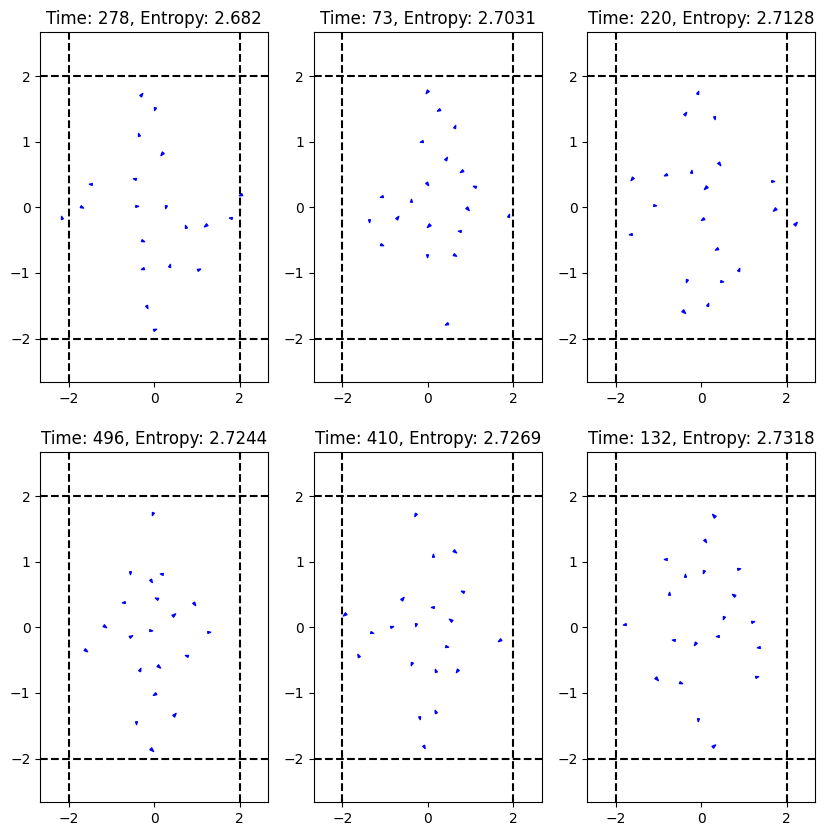

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10)) 
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
for i in range(2):
    for j in range(3):
        moment = minor_indexes[j+i*3]
        points = ps[moment,:,:]
        x = points[:, 0]
        y = points[:, 1]
        angle = points[:, 2]
        for (a,b,c) in zip(x,y,angle):
            marker, scale = fu.gen_arrow_head_marker(c)
            markersize = 25
            axs[i,j].scatter(a,b,marker=marker,c="blue", s=20)
        axs[i,j].set_title(f"Time: {moment}, Entropy: {entropies[moment]}")
for ax in axs.flat:
    ax.set_xlim([-sideLength/1.5,sideLength/1.5])
    ax.set_ylim([-sideLength/1.5,sideLength/1.5])
    ax.axhline(y=-sideLength/2, color='black',linestyle="--")
    ax.axhline(y=sideLength/2, color='black',linestyle="--")
    ax.axvline(x=-sideLength/2, color='black',linestyle="--")
    ax.axvline(x=sideLength/2, color='black',linestyle="--")
plt.savefig(f'Images/CrossLowerEntropy{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

Point clouds with bigger entropy

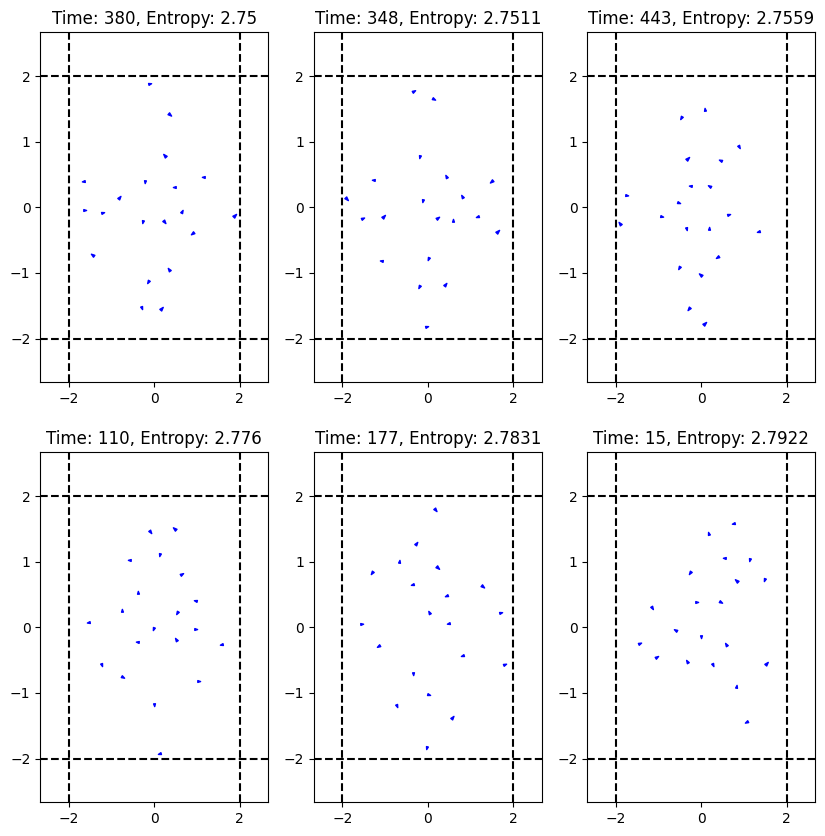

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10)) 
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
for i in range(2):
    for j in range(3):
        moment = major_indexes[j+i*3]
        points = ps[moment,:,:]
        x = points[:, 0]
        y = points[:, 1]
        angle = points[:, 2]
        for (a,b,c) in zip(x,y,angle):
            marker, scale = fu.gen_arrow_head_marker(c)
            markersize = 25
            axs[i,j].scatter(a,b,marker=marker,c="blue", s=20)
        axs[i,j].set_title(f"Time: {moment}, Entropy: {entropies[moment]}")
for ax in axs.flat:
    ax.set_xlim([-sideLength/1.5,sideLength/1.5])
    ax.set_ylim([-sideLength/1.5,sideLength/1.5])
    ax.axhline(y=-sideLength/2, color='black',linestyle="--")
    ax.axhline(y=sideLength/2, color='black',linestyle="--")
    ax.axvline(x=-sideLength/2, color='black',linestyle="--")
    ax.axvline(x=sideLength/2, color='black',linestyle="--")
plt.savefig(f'Images/CrossHigherEntropy{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

If we look at the time instants of the different deciles in reference to the entropy time series:

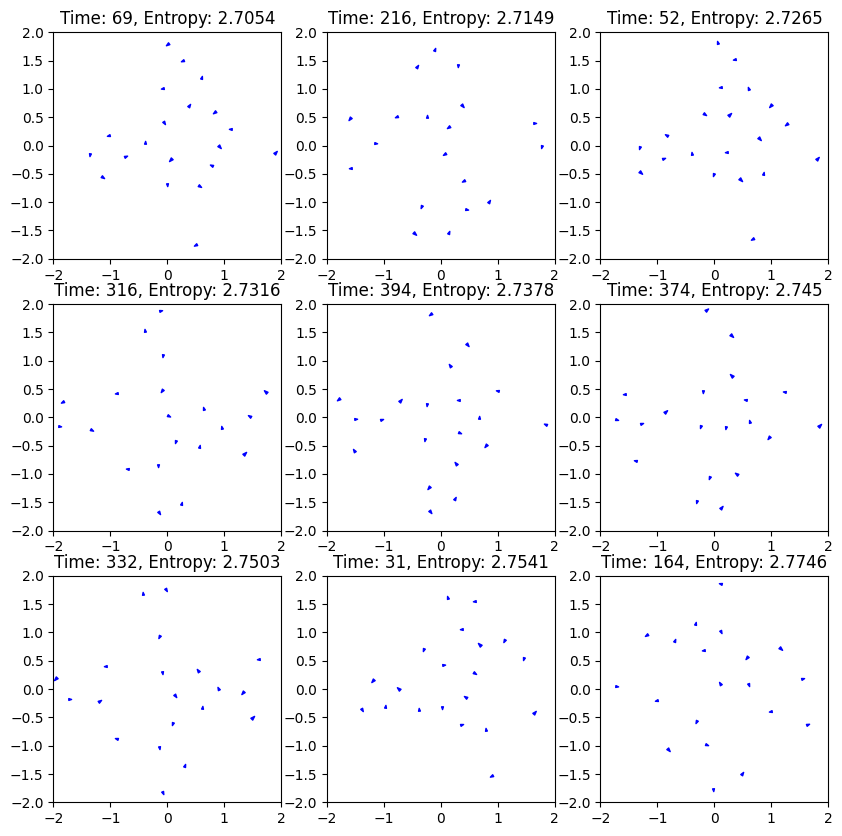

In [35]:
percentiles = np.percentile(entropies, np.arange(10, 101, 10))
indexes = [np.abs(entropies - p).argmin() for p in percentiles]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10)) 
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
for i in range(3):
    for j in range(3):
        moment = indexes[3*i+j]
        points = ps[moment,:,:]
        x = points[:, 0]
        y = points[:, 1]
        angle = points[:, 2]
        for (a,b,c) in zip(x,y,angle):
            marker, scale = fu.gen_arrow_head_marker(c)
            markersize = 25
            axs[i,j].scatter(a,b,marker=marker,c="blue", s=20)
        axs[i,j].set_title(f"Time: {moment}, Entropy: {entropies[moment]}")
for ax in axs.flat:
    ax.set_xlim([-sideLength/2,sideLength/2])
    ax.set_ylim([-sideLength/2,sideLength/2])
plt.savefig(f'Images/CrossPercentilesEntropy{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

We can say about persistent entropy for explain how the robots are distributed in the space that: 

- Higher entropy:
    - Intervals in the persistence barcode are more evenly distributed in length
    - Suggests greater dispersion among the robots, so that the distribution of the robots is more uniform, without clusters of robots in certain areas and without empty areas or areas with few robots
- Lower entropy:
    - Intervals in the persistence barcode are more uneven distributed
    - Suggests less dispersion of the robots around the robots, so that some robots are somewhat clustered together in one area of space, and others are further apart in another area of space, leaving areas of space somewhat empty.
      
Next, we are going to compare entropy difference between two consecutive time periods in terms of large changes and smaller changes. The intention here is to test whether a larger persistent entropy change is related to a larger change of the robots in space, i.e. a larger displacement of the robots between these instants, while a smaller change should be linked to the fact that the robots are still distributed more similarly between two consecutive time instants.

In [32]:
changes = np.abs(np.diff(entropies))
major_index_changes = np.argsort(changes)[-9:]
minor_index_changes = np.argsort(changes)[:9]

Comparing times with large entropy change

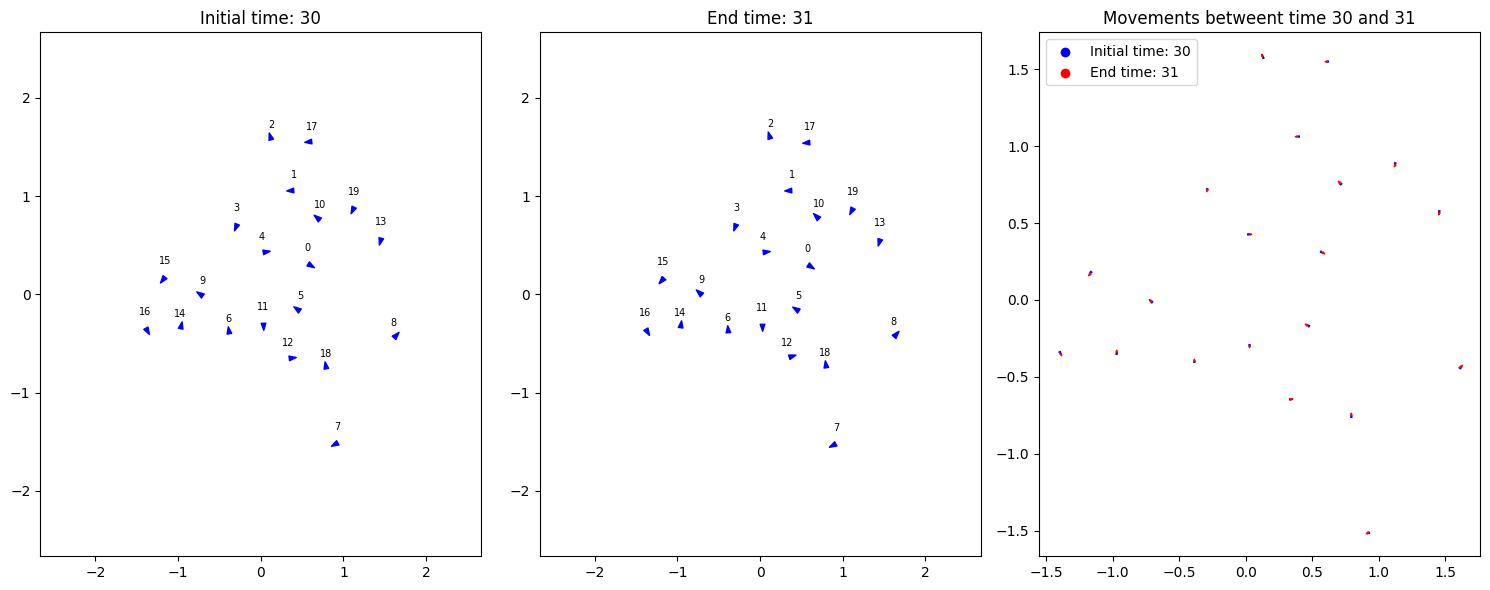

The total distance moved between the instances 30 and 31 is 0.2150660041502345


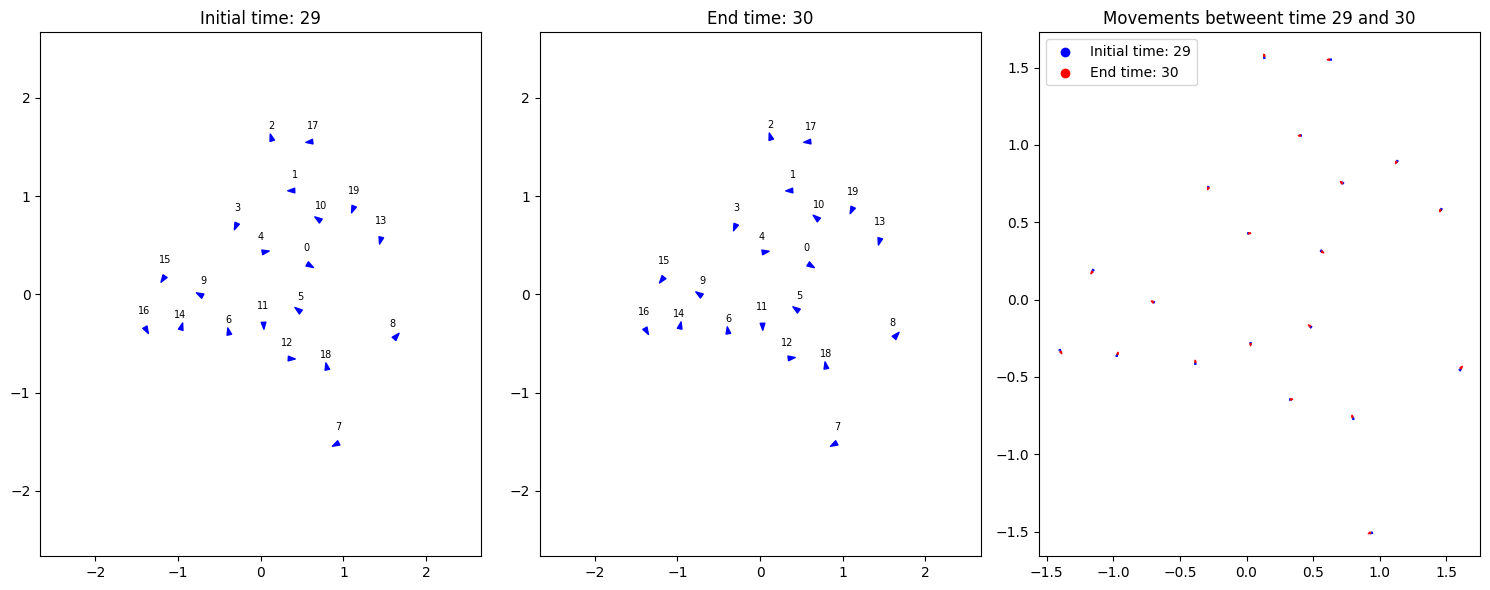

The total distance moved between the instances 29 and 30 is 0.21358290572010505


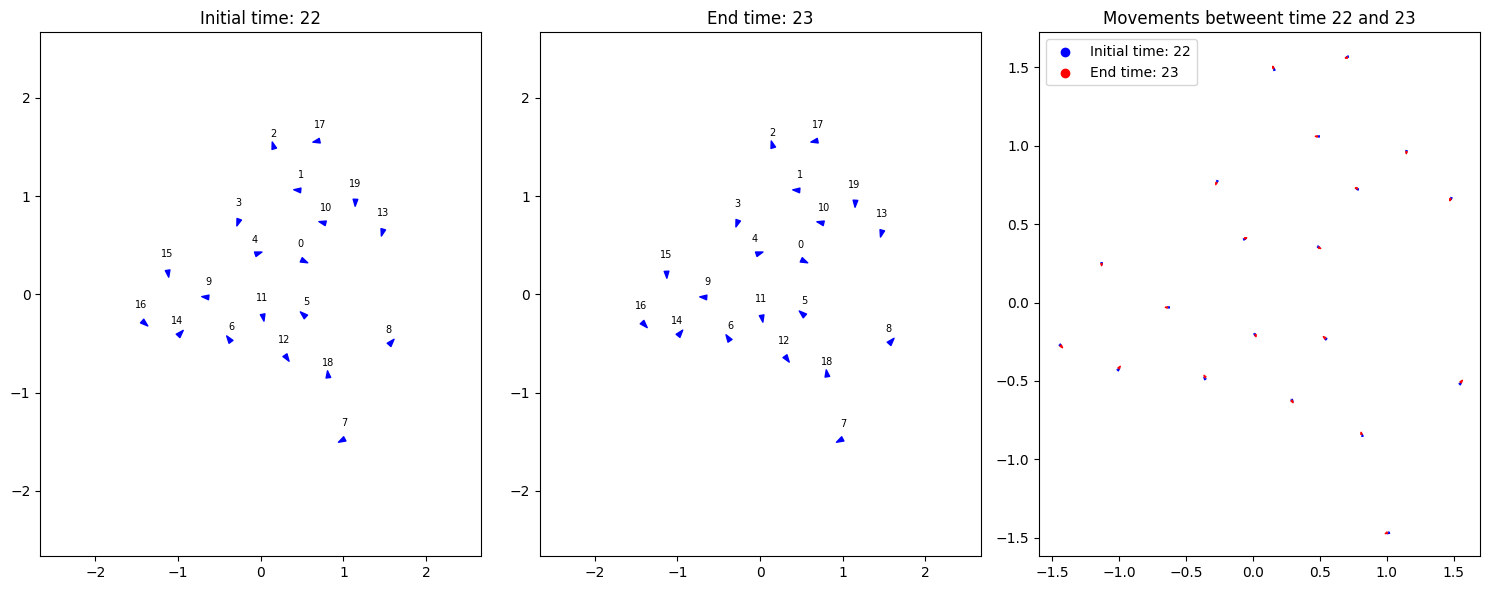

The total distance moved between the instances 22 and 23 is 0.22401227832118972


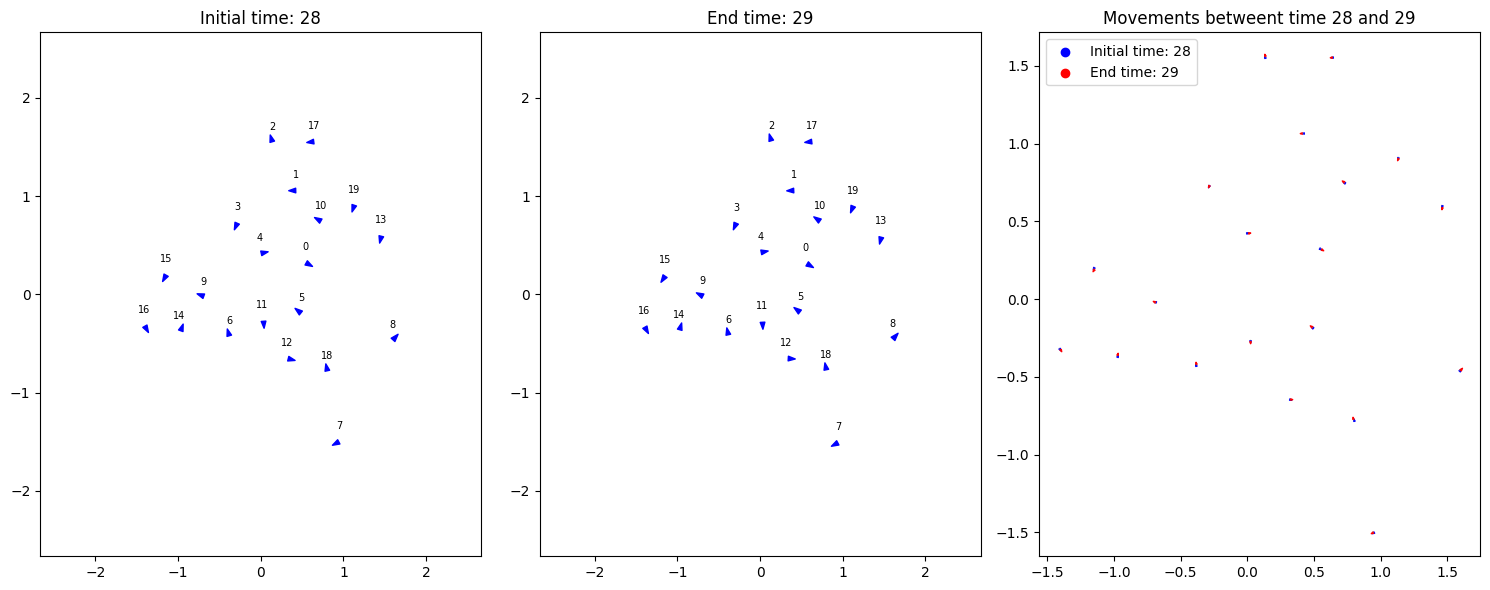

The total distance moved between the instances 28 and 29 is 0.21233216864251986


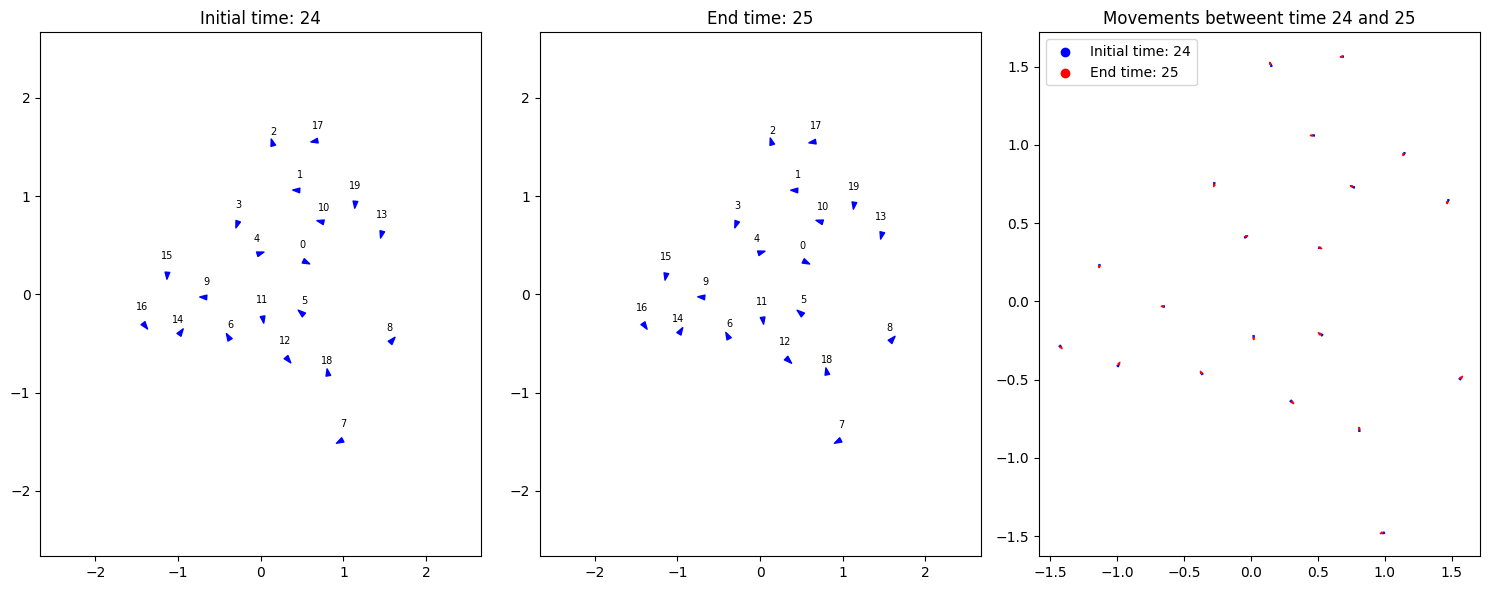

The total distance moved between the instances 24 and 25 is 0.21719653807460293


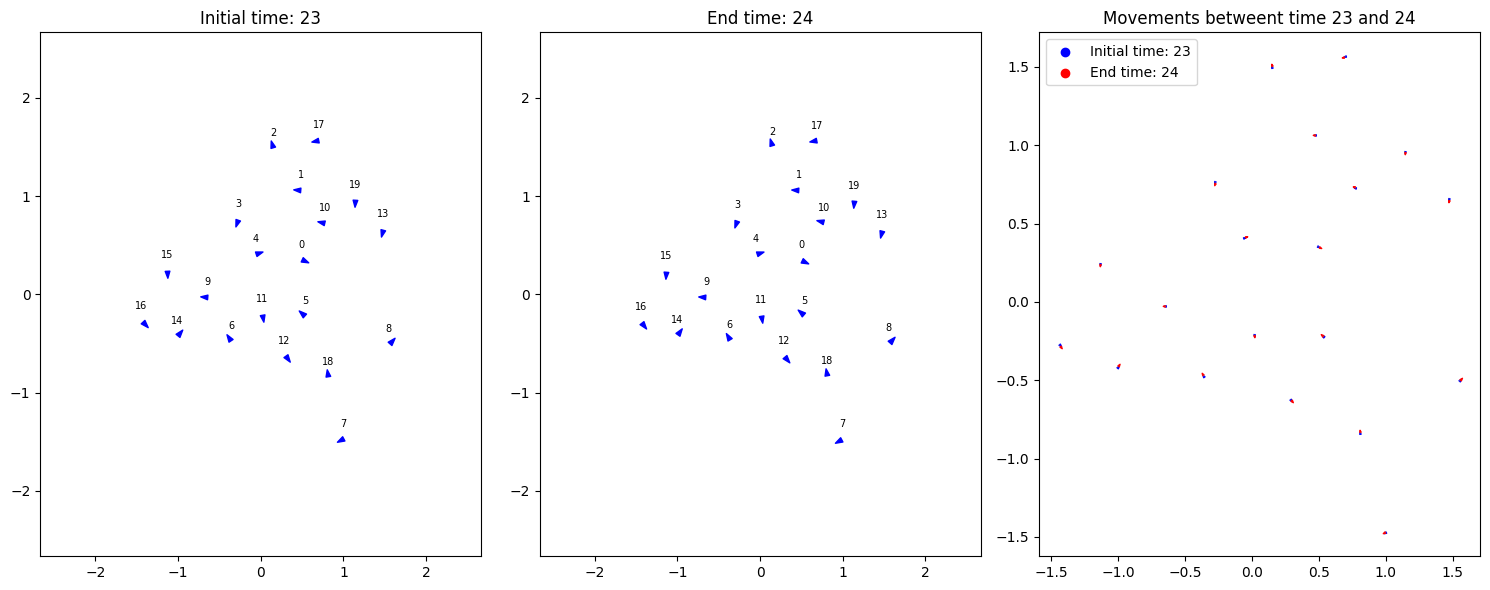

The total distance moved between the instances 23 and 24 is 0.22079112376990015


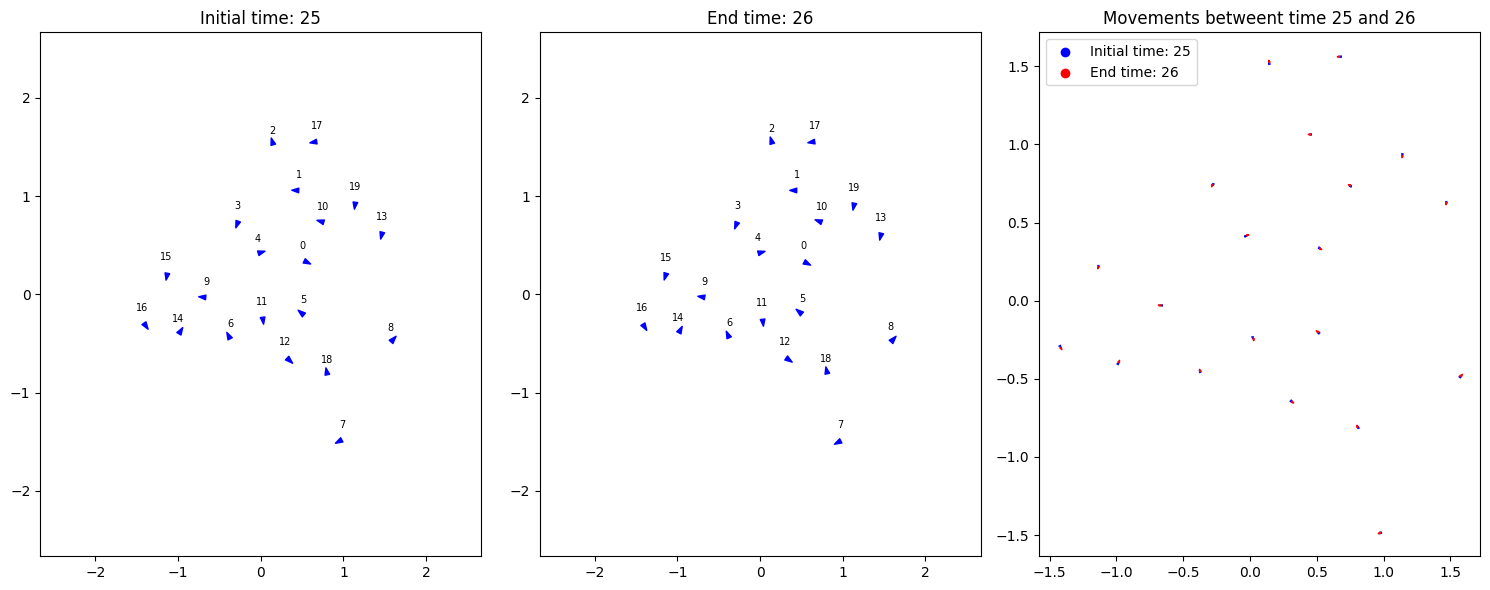

The total distance moved between the instances 25 and 26 is 0.21417633817355713


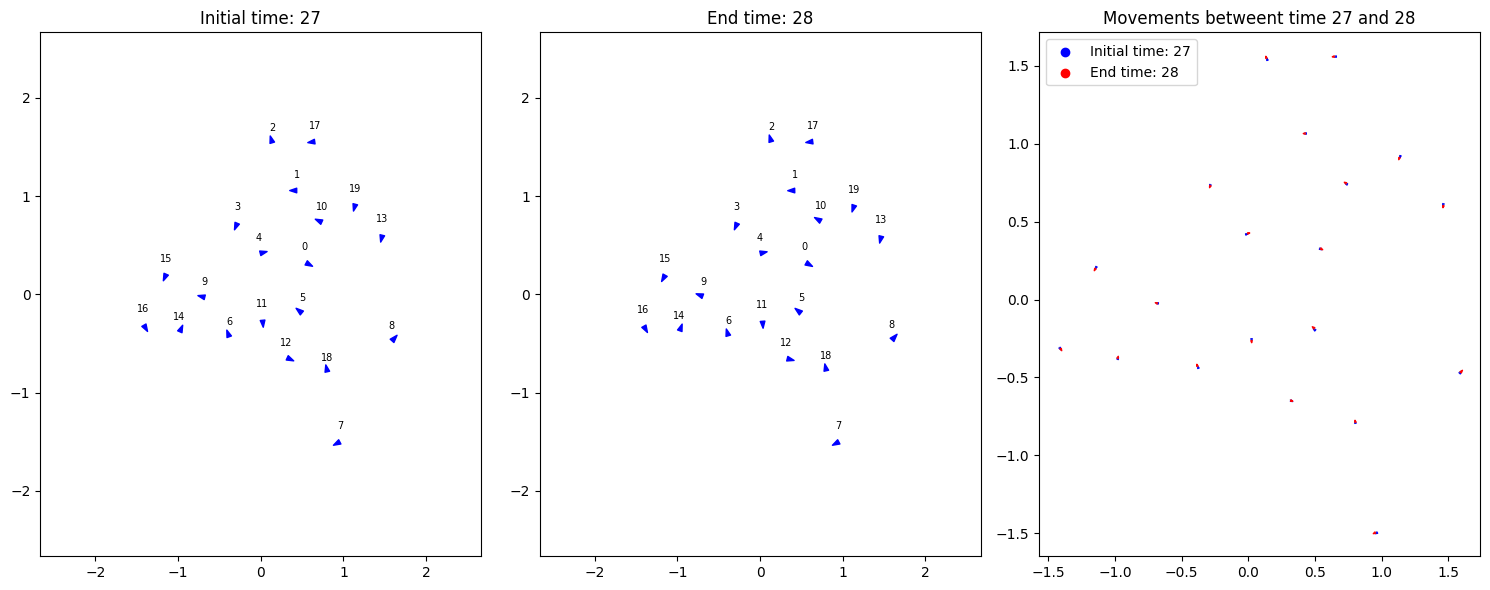

The total distance moved between the instances 27 and 28 is 0.21203232606124806


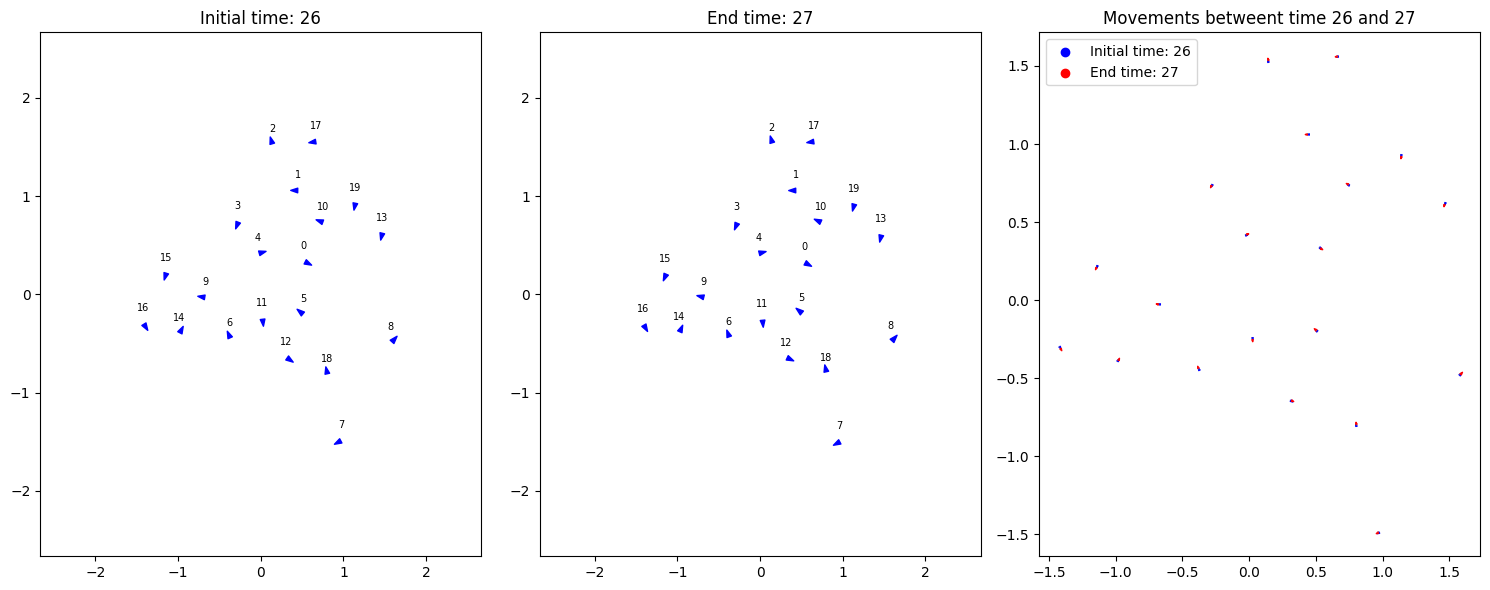

The total distance moved between the instances 26 and 27 is 0.2126620638574361


In [33]:
for i in major_index_changes:
    fu.plotPointCloud2Moments(ps,i-1,i,length=sideLength,width=sideLength)
    plt.show()
    distances=[]
    for j in range(robots):
        x1=ps[i-1,j,0]
        y1=ps[i-1,j,1]
        x2=ps[i,j,0]
        y2=ps[i,j,1]
        distance=fu.calculate_distance(x1,y1,x2,y2)
        distances.append(distance)
    print(f"The total distance moved between the instances {i-1} and {i} is {sum(distances)}")

Comparing times with very slight entropy change

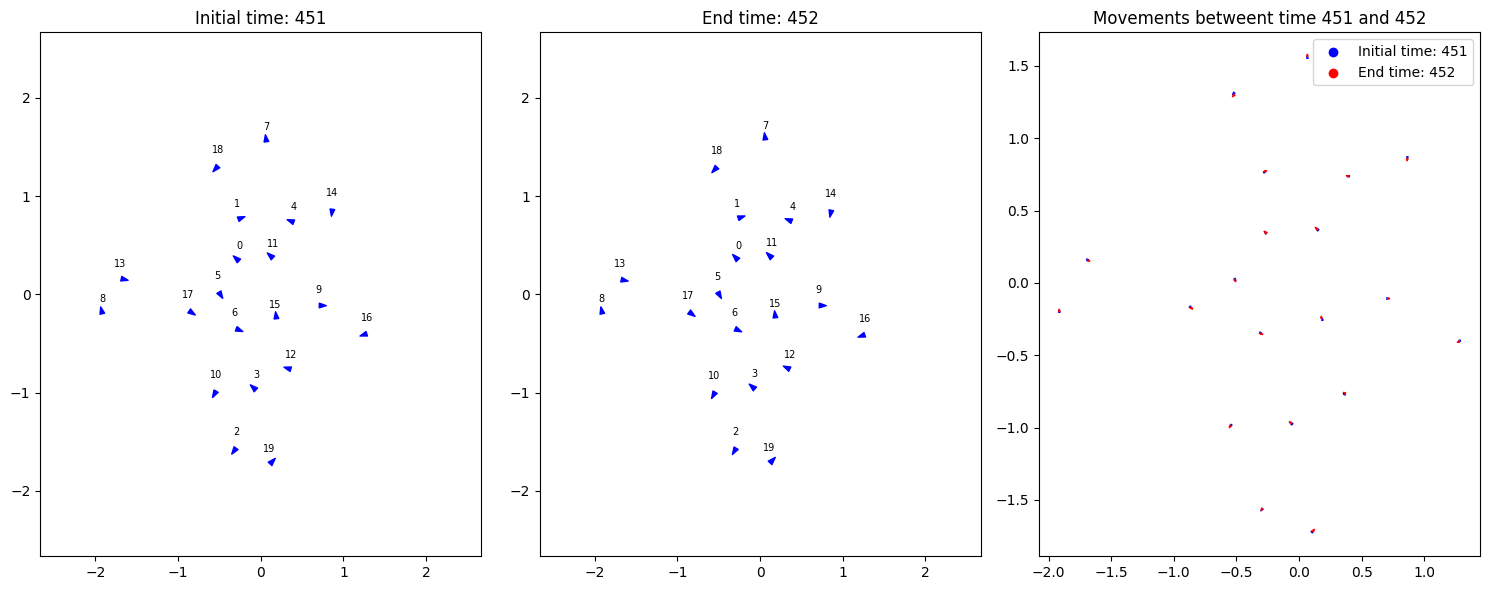

The total distance moved between the instances 451 and 452 is 0.18875502895895205


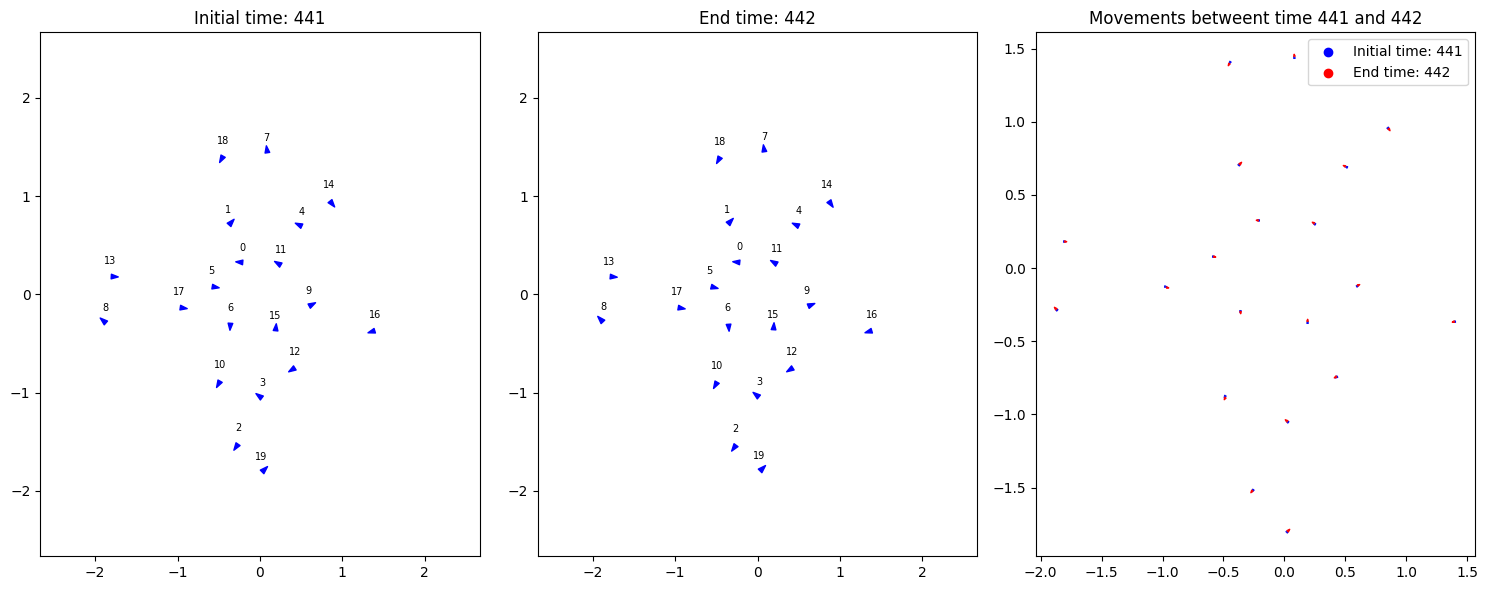

The total distance moved between the instances 441 and 442 is 0.20671388255322354


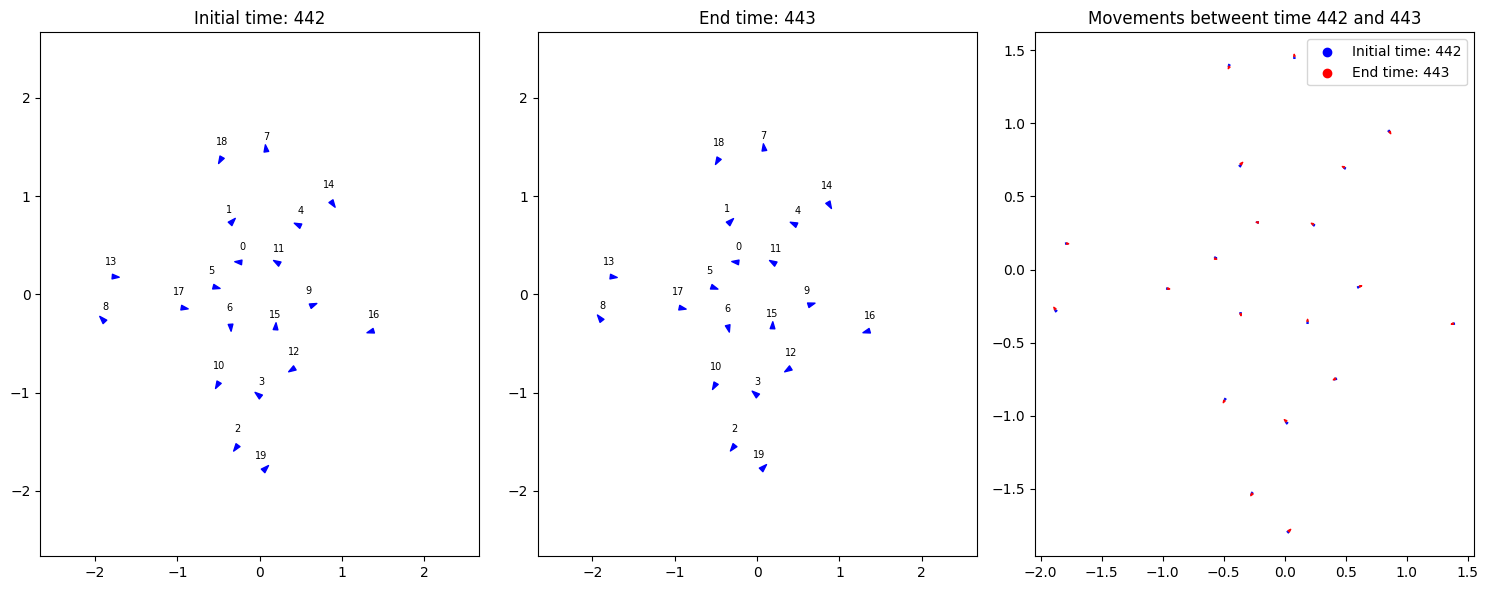

The total distance moved between the instances 442 and 443 is 0.20815079386313992


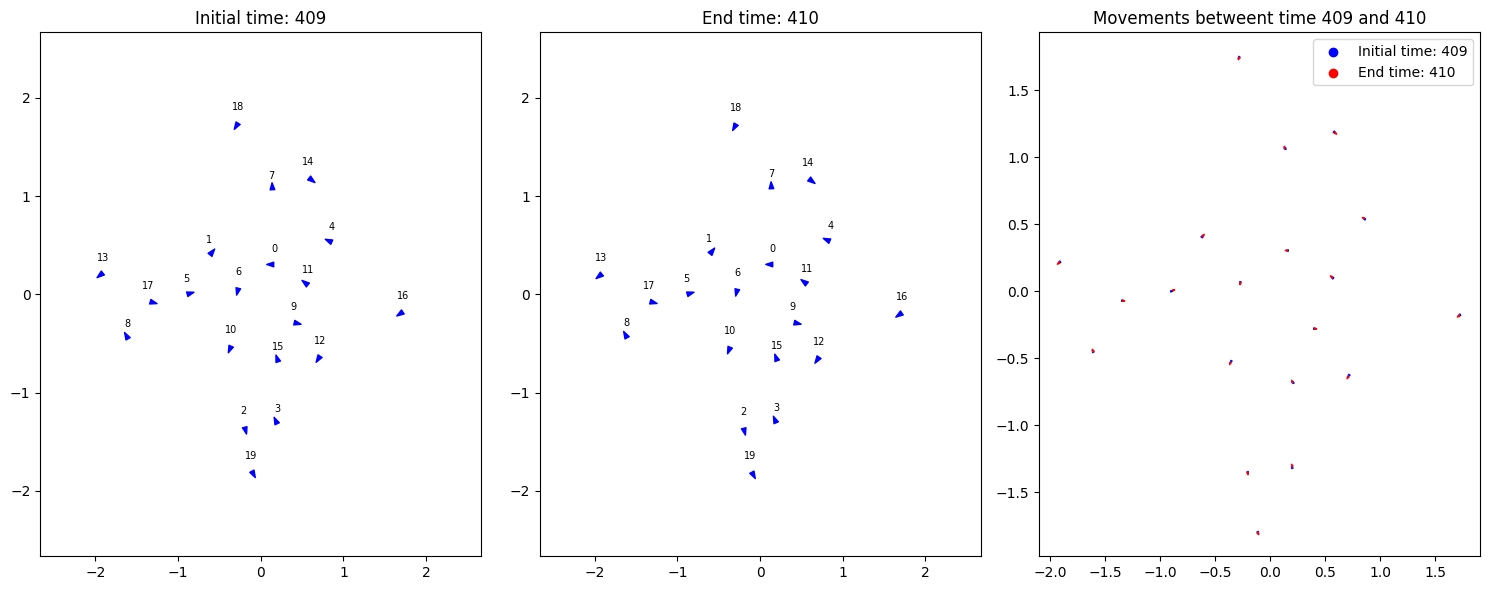

The total distance moved between the instances 409 and 410 is 0.21962044360827057


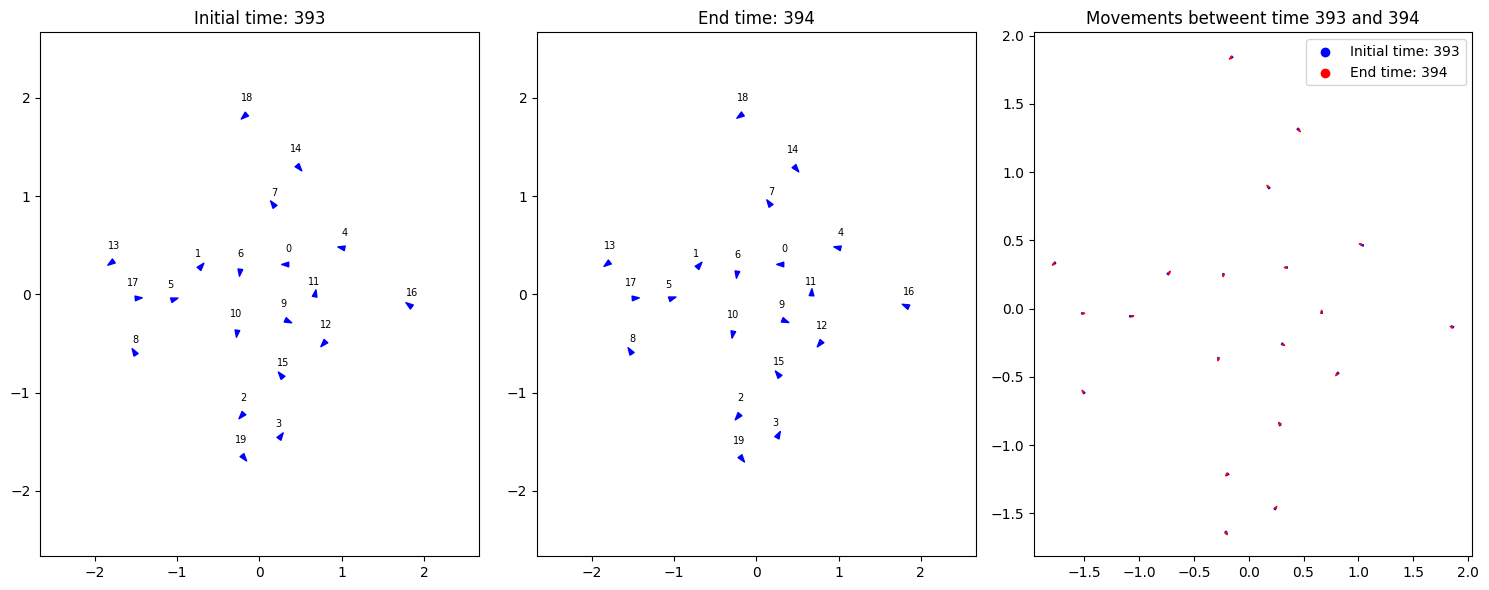

The total distance moved between the instances 393 and 394 is 0.2068637146636433


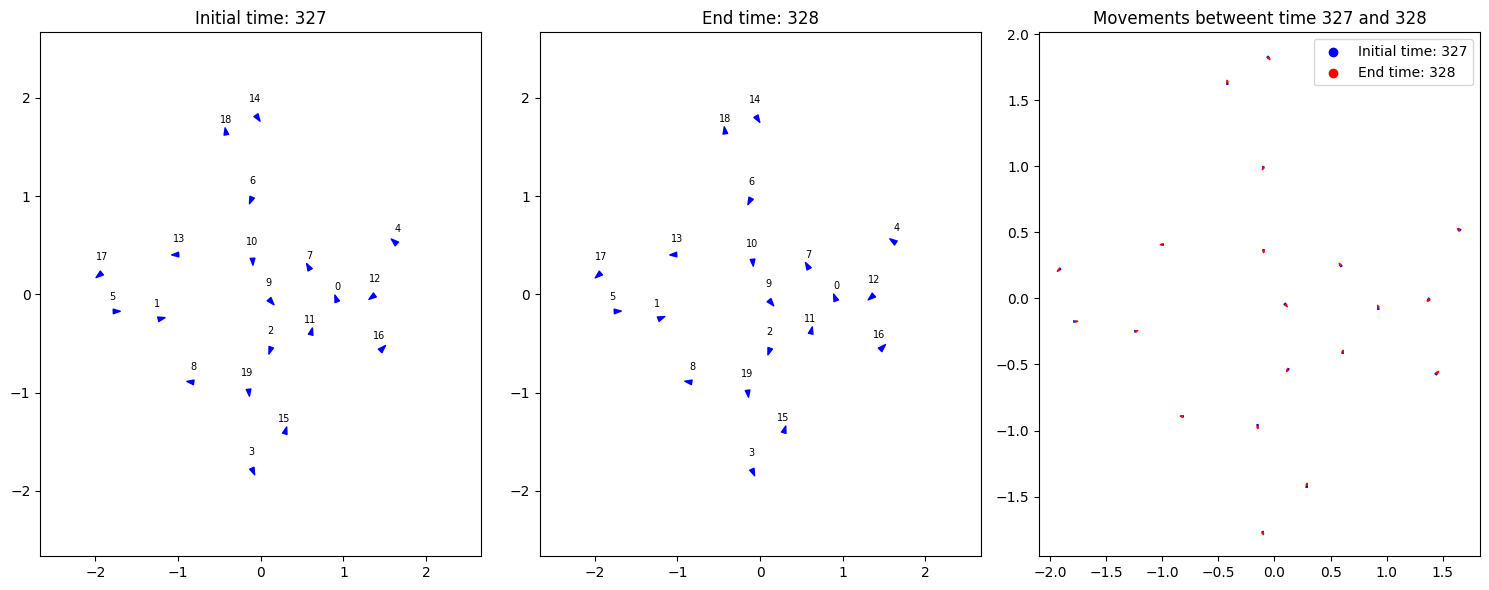

The total distance moved between the instances 327 and 328 is 0.21823844822986793


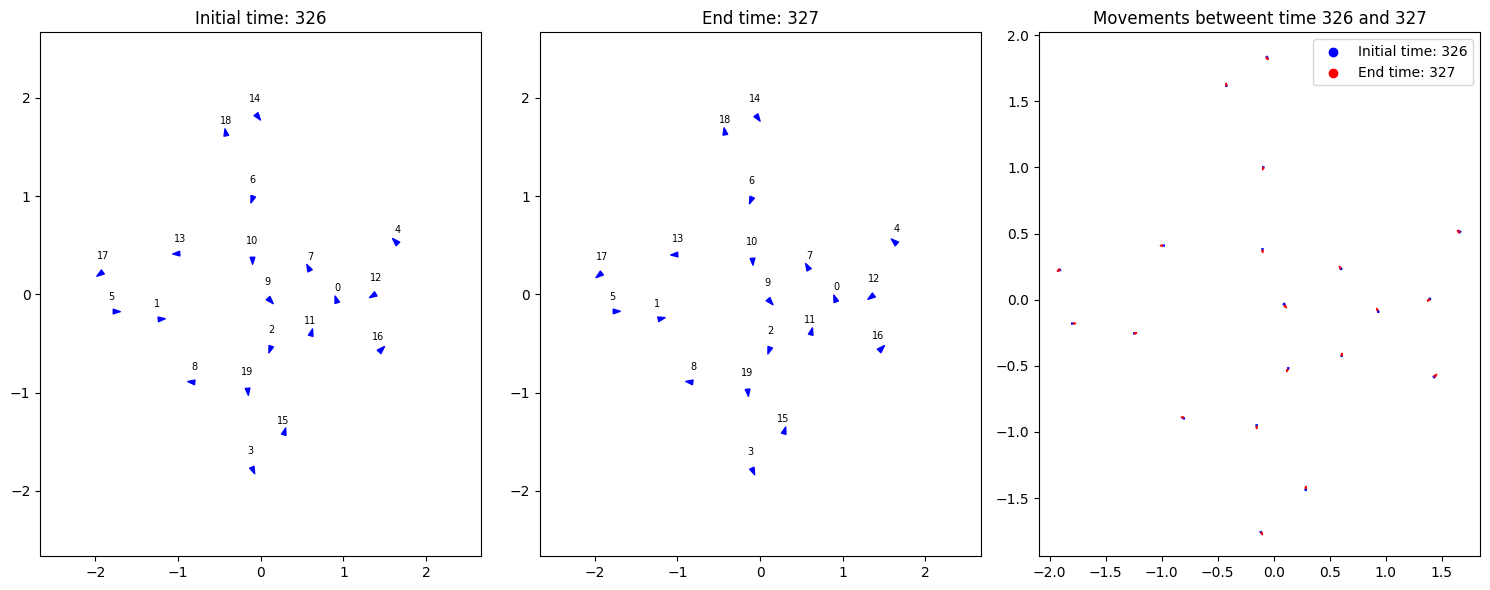

The total distance moved between the instances 326 and 327 is 0.22154081195673334


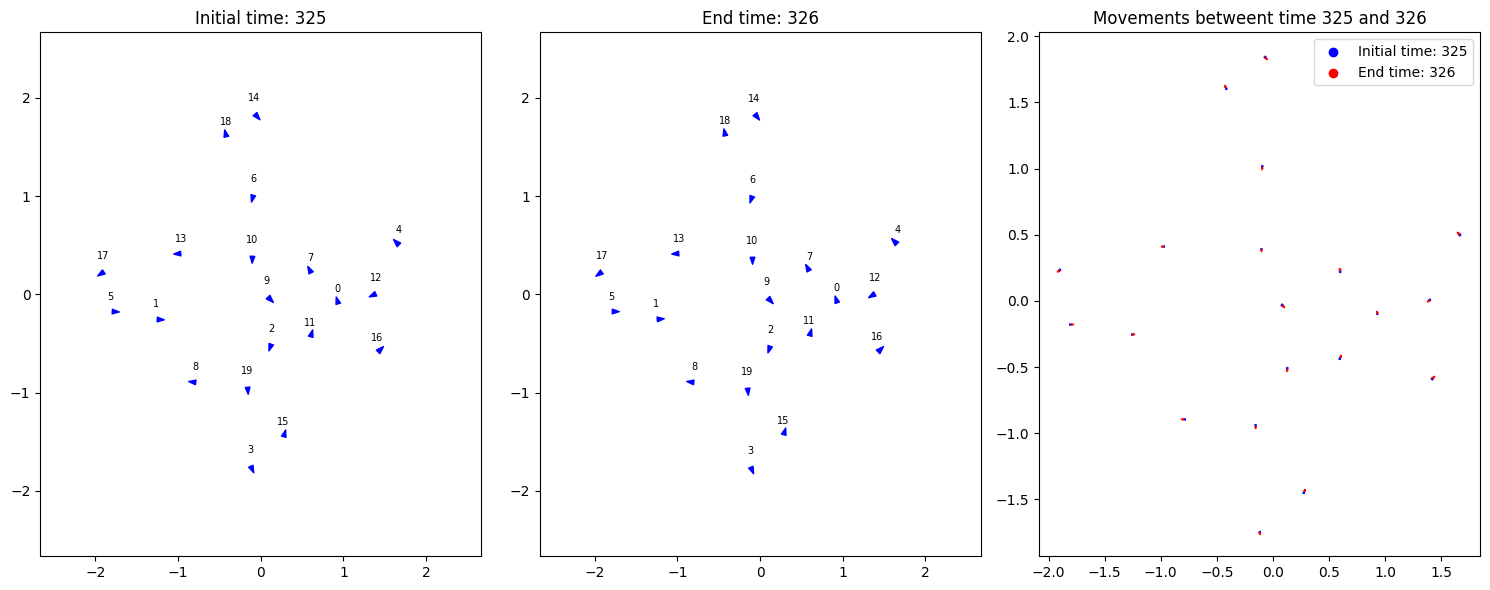

The total distance moved between the instances 325 and 326 is 0.22364513048183088


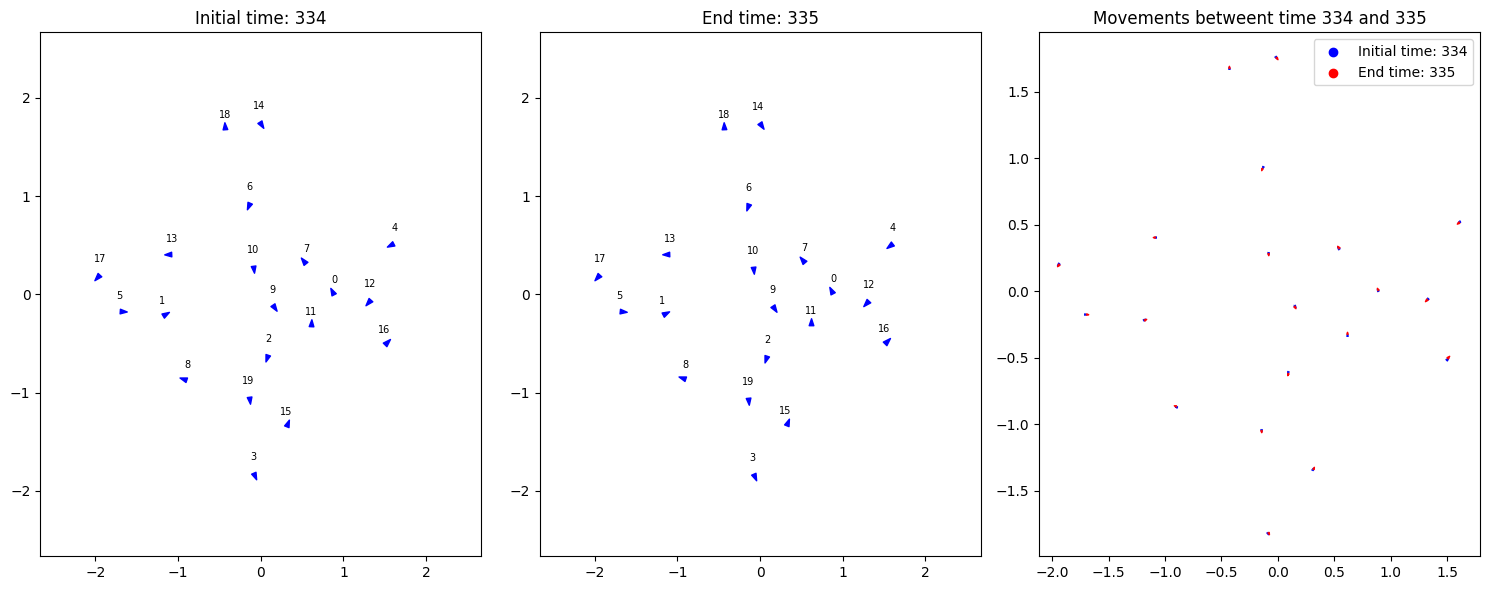

The total distance moved between the instances 334 and 335 is 0.2005962587756342


In [36]:
for i in minor_index_changes:
    fu.plotPointCloud2Moments(ps,i-1,i,length=sideLength,width=sideLength)
    plt.show()
    distances=[]
    for j in range(robots):
        x1=ps[i-1,j,0]
        y1=ps[i-1,j,1]
        x2=ps[i,j,0]
        y2=ps[i,j,1]
        distance=fu.calculate_distance(x1,y1,x2,y2)
        distances.append(distance)
    print(f"The total distance moved between the instances {i-1} and {i} is {sum(distances)}")

If we study the correlation between the entropy changes and the total motion distance between two instants of time. We use Pearson's correlation, as we seek to study the linear correlation between two variables, being these variables continuous and approximately normal (tested with the Shapiro-Wilk test).

Shapiro-Wilk Statistic: 0.911390853370319, P-value: 1.7402708761761413e-16
Shapiro-Wilk Statistic: 0.8044864998076021, P-value: 4.252048479448715e-24
Pearson's correlation coefficient: 0.20674817863466372
P-value: 3.204866651861874e-06
The correlation is statistically significant.


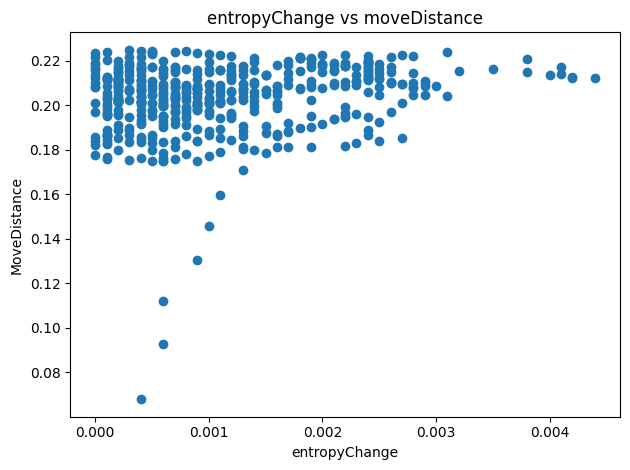

In [37]:
entropyChange=[]
totalMoveDistance=[]
medianMoveDistance=[]
for j in range(time_instances-1):
    time1=j
    time2=j+1
    distances=[]
    for i in range(robots):
        x1=ps[time1,i,0]
        y1=ps[time1,i,1]
        x2=ps[time2,i,0]
        y2=ps[time2,i,1]
        distance=fu.calculate_distance(x1,y1,x2,y2)
        distances.append(distance)
    totalMoveDistance.append(sum(distances))
    medianMoveDistance.append(np.median(distances))
    entropyChange.append(abs(entropies[time2]-entropies[time1]))

stat, p_value1 = shapiro(entropyChange)
print(f'Shapiro-Wilk Statistic: {stat}, P-value: {p_value1}')
stat, p_value2 = shapiro(totalMoveDistance)
print(f'Shapiro-Wilk Statistic: {stat}, P-value: {p_value2}')

fu.show_correlation(entropyChange,totalMoveDistance)

plt.scatter(entropyChange,totalMoveDistance,marker="o")
plt.title(f"entropyChange vs moveDistance")
plt.xlabel(f"entropyChange")
plt.ylabel('MoveDistance')
plt.tight_layout()
plt.show()

We found a slightly significant correlation, meaning that if there is a larger persistent entropy change in space due to the robots' movement between two consecutive instants, the total distance traveled by the robots will be greater than in instants with lower or slight entropy changes, where the robots move less.

All this has been used to explain the situation of robots at a given instant of time and its relation to entropy, but what if we calculate the persistent entropy of a robot only with those within its field of view, so that this is able to explain future movements. (This is not going to be included on the deliverable, as we don't have more time for it.) Let's look at an example where we calculate the robots that are within the field of view of a robot.

Time 0. Robots in the robot's 0 field of vision: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


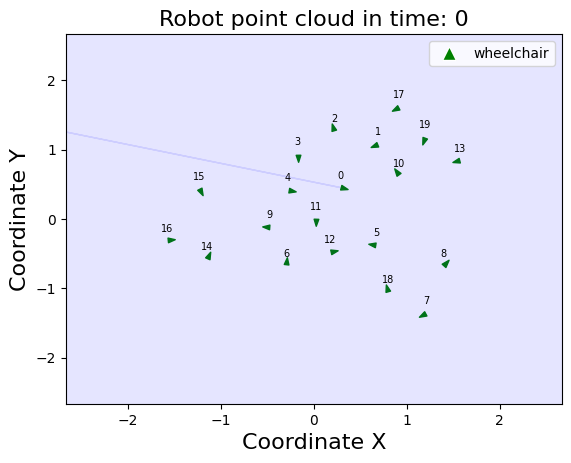

In [40]:
time=0
robot=0
angleVision=2*np.pi
fu.calculate_robots_in_field_vision(ps,time,robot,radioVision,angleVision,printing=True)
fu.plotPointCloudMoment(ps,time,sideLength,sideLength,typeAgents,robot,radioVision,angleVision,ids=True)

In this generate gif, we can see the path a robot takes, as well as its field of vision. We calculate his topological entropy in each time respecting the robots in his field of vision

 90%|█████████████████████████████████████████████████████████████████████████        | 451/500 [02:19<00:25,  1.92it/s]

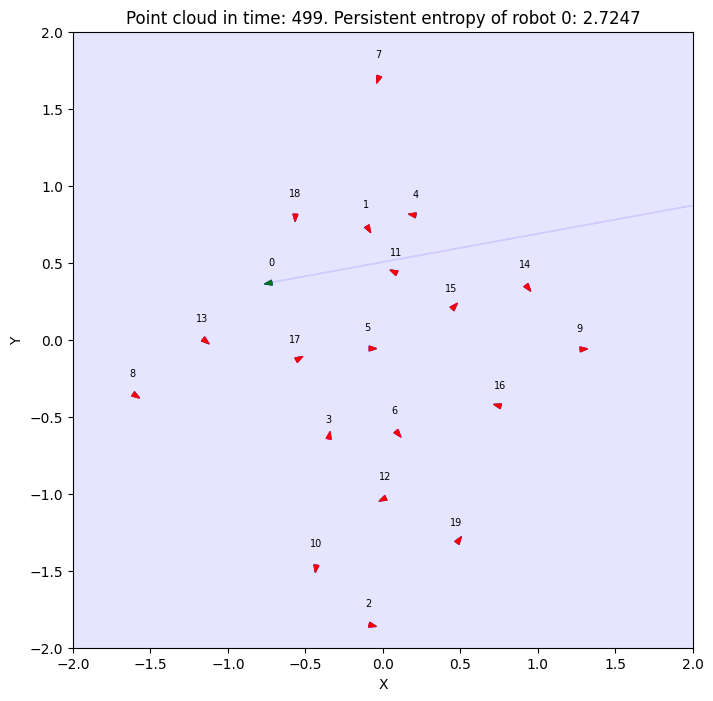

In [42]:
ids = True
robotVision = 0  #robot ID which will display his field vision

def update(frame):
    plt.clf() 
    moment = ps[frame]
    x = moment[:, 0]
    y = moment[:, 1]
    angle = moment[:, 2]
    for (a,b,c) in zip(x,y,angle):
        marker, scale = fu.gen_arrow_head_marker(c)
        markersize = 25
        plt.scatter(a,b,marker=marker,c="blue", s=(markersize*scale)**1.5)
    plt.xlim([-sideLength/2,sideLength/2])
    plt.ylim([-sideLength/2,sideLength/2])
    
    if ids:
        for i in range(len(x)):
            plt.text(x[i], y[i]+0.1, str(i), fontsize=7, ha='center', va='bottom')
    
    if robotVision is not None:
        vision_radius = radioVision
        field_of_view = angleVision
        xrobot = x[robotVision]
        yrobot = y[robotVision]
        orientation = angle[robotVision]
        marker, scale = fu.gen_arrow_head_marker(orientation)
        markersize = 25
        plt.scatter(xrobot,yrobot,marker=marker,c="green", s=(markersize*scale)**1.5)
        arc_points = [[xrobot, yrobot]]

        num_points = 50
        for i in range(num_points + 1):
            angles = orientation + field_of_view / 2 - (i / num_points) * field_of_view
            arc_points.append([xrobot + vision_radius * np.cos(angles), yrobot + vision_radius * np.sin(angles)])
        arc_points.append([xrobot, yrobot])
        arc_points = np.array(arc_points)
        # plt.plot(arc_points[:, 0], arc_points[:, 1], 'b-', alpha=0.3)
        plt.fill(arc_points[:, 0], arc_points[:, 1], color='blue', alpha=0.1)
        robotsCV=fu.calculate_robots_in_field_vision(ps,frame,robotVision,radioVision,angleVision,)
        xCV, yCV, angleCV = x[robotsCV], y[robotsCV], angle[robotsCV]
        for (a,b,c) in zip(xCV,yCV,angleCV):
            marker, scale = fu.gen_arrow_head_marker(c)
            markersize = 25
            plt.scatter(a,b,marker=marker,c="red", s=(markersize*scale)**1.5)
        robotsCV.append(robotVision)
    else:
        robotsCV=[i for i in range(0,robots)]
        
    persistence = fu.ComputePersistenceDiagram(ps,frame,0,"rips",robotsSelected=robotsCV)
    persistenceL = fu.limitingDiagram(persistence,maxd[frame])
    if len(robotsCV) < 3:
        entropy = None
    else:
        entropy = fu.EntropyCalculationFromBarcode(persistenceL)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Point cloud in time: {frame}. Persistent entropy of robot {robotVision}: {entropy}')

fig = plt.figure(figsize=(8, 8))
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(time_instances)))
ani.save(filename=f"Images/RobotMovementVisionCross{behavior}.gif", writer="pillow")
plt.show()